# Generación de los modelos de predicción

    - Autor: Peio García Pinilla
    - Fecha: Julio de 2021
    
Este notebook hace referencia al Proyecto Fin de Máster: "Modelo Machine-Learning Del Cerebelo Para Adaptación De Movimientos Oculares". En él se lleva a cabo la implementación, generación, entrenamiento y evaluación de todas las redes neuronales del proyecto.

In [409]:
import os
import os.path
import sys
from os import listdir
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
import graphviz
import pydot
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

#Grafico de evolucion del entrenamiento https://sitiobigdata.com/2018/10/01/redes-neuronales-profundas-problemas-regresion/#
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
               label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val loss')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
               label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
               label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

In [410]:
#Cargar dataset
DF = pd.read_csv('DATAFRAME.csv')

C:\Users\peiog\anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,1,3,4,6,7,9,10,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [411]:
#Numero de epoch
EPOCHS = 100

In [412]:
#Forzar conversion a float
DF = DF.drop(1925)
DF["HE"] = pd.to_numeric(DF["HE"], downcast="float")
DF["VE"] = pd.to_numeric(DF["VE"], downcast="float")
DF["HF"] = pd.to_numeric(DF["HF"], downcast="float")
DF["VF"] = pd.to_numeric(DF["VF"], downcast="float")

DF["VXmax"] = pd.to_numeric(DF["VXmax"], downcast="float")
DF["VYmax"] = pd.to_numeric(DF["VYmax"], downcast="float")
DF["a1x"] = pd.to_numeric(DF["a1x"], downcast="float")
DF["a2x"] = pd.to_numeric(DF["a2x"], downcast="float")
DF["a1y"] = pd.to_numeric(DF["a1y"], downcast="float")
DF["a2y"] = pd.to_numeric(DF["a2y"], downcast="float")

## Modelo 1: VMax como input

### Eje horizontal

In [413]:
def build_model_vmax():
#     model = keras.Sequential([
#         layers.Dense(64, activation='relu', input_shape=[2]),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(1)
#       ])

#     optimizer = tf.keras.optimizers.RMSprop(0.001)

#     model.compile(loss='mse',
#                 optimizer=optimizer,
#                 metrics=['mae', 'mse'])
#     return model
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 2, activation='relu'))
    #Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    return(NN_model)

model_H = build_model_vmax()
model_V = build_model_vmax()
model_H.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_329 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_330 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_331 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_332 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_333 (Dense)            (None, 1)                 257       
Total params: 165,249
Trainable params: 165,249
Non-trainable params: 0
_________________________________________________________________


In [414]:
#Definimos conjunto train-test HORIZONTAL
aux= DF[['HE','VXmax','HF']]
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['HF'].copy()
xtrain = train_dataset.drop(['HF'], axis=1)
ytest = test_dataset['HF'].copy()
xtest = test_dataset.drop(['HF'], axis=1)

aux

,HE,VXmax,HF
0,-0.250244,-497.436523,-14.898682
1,-12.518311,476.074219,0.634766
2,-0.445557,57.983398,0.436401
3,0.112915,15.258789,-1.303101
4,-0.476074,21.362305,-0.537109
...,...,...,...
119671,-9.442139,204.467773,-1.043701
119672,-3.060913,415.039062,7.403564
119673,2.679443,-408.935547,-6.262207
119674,-4.071045,323.486328,3.842163


In [415]:
#Entrenamos modelo horizontal
model_H.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_H.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.2623 - mean_absolute_error: 3.2623 - val_loss: 2.5413 - val_mean_absolute_error: 2.5413
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4931 - mean_absolute_error: 2.4931 - val_loss: 2.4131 - val_mean_absolute_error: 2.4131
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.3923 - mean_absolute_error: 2.3923 - val_loss: 2.3064 - val_mean_absolute_error: 2.3064
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.3457 - mean_absolute_error: 2.3457 - val_loss: 2.2948 - val_mean_absolute_error: 2.2948
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.3316 - mean_absolute_error: 2.3316 - val_loss: 2.2502 - val_mean_absolute_error: 2.2502
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2828 - mean_absolute_error: 2.2828 - val_loss: 2.2293 - val_mean_absolute_error: 2.229

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1854 - mean_absolute_error: 2.1854 - val_loss: 2.1540 - val_mean_absolute_error: 2.1540
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1785 - mean_absolute_error: 2.1785 - val_loss: 2.1639 - val_mean_absolute_error: 2.1639
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1713 - mean_absolute_error: 2.1713 - val_loss: 2.2000 - val_mean_absolute_error: 2.2000
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1797 - mean_absolute_error: 2.1797 - val_loss: 2.1448 - val_mean_absolute_error: 2.1448
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1708 - mean_absolute_error: 2.1708 - val_loss: 2.1584 - val_mean_absolute_error: 2.1584
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1554 - mean_absolute_error: 2.1554 - val_loss: 2.1687 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1455 - mean_absolute_error: 2.1455 - val_loss: 2.1474 - val_mean_absolute_error: 2.1474
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1541 - mean_absolute_error: 2.1541 - val_loss: 2.1969 - val_mean_absolute_error: 2.1969


In [416]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,2.147960,2.147960,2.161630,2.161630,95
96,2.152033,2.152033,2.140930,2.140930,96
97,2.145059,2.145059,2.189858,2.189858,97
98,2.144878,2.144878,2.147435,2.147435,98
99,2.152739,2.152739,2.196871,2.196871,99


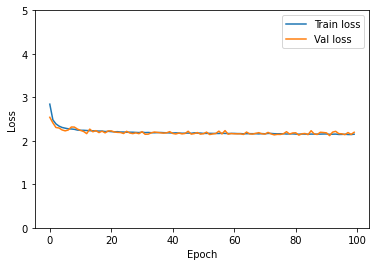

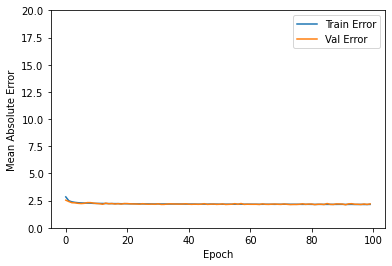

In [417]:
plot_history(history)

### Eje vertical

In [418]:
#Definimos conjunto train-test VERTICAL
aux= DF[['VE','VYmax','VF']]
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['VF'].copy()
xtrain = train_dataset.drop(['VF'], axis=1)
ytest = test_dataset['VF'].copy()
xtest = test_dataset.drop(['VF'], axis=1)

aux

,VE,VYmax,VF
0,-0.100708,33.569336,0.262451
1,-0.186157,36.621094,-0.222778
2,-0.399780,552.368164,14.346313
3,11.608887,-527.954102,-2.374268
4,-0.350952,-494.384766,-13.647461
...,...,...,...
119671,-0.549316,152.587891,2.886963
119672,0.125122,33.569336,0.238037
119673,0.180054,42.724609,0.701904
119674,-0.018311,30.517578,-0.012207


In [419]:
#Entrenamos modelo
model_V.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_V.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.9016 - mean_absolute_error: 2.9016 - val_loss: 2.5176 - val_mean_absolute_error: 2.5176
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2055 - mean_absolute_error: 2.2055 - val_loss: 2.1299 - val_mean_absolute_error: 2.1299
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.0421 - mean_absolute_error: 2.0421 - val_loss: 2.0072 - val_mean_absolute_error: 2.0072
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.0191 - mean_absolute_error: 2.0191 - val_loss: 1.9034 - val_mean_absolute_error: 1.9034
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.0014 - mean_absolute_error: 2.0014 - val_loss: 2.0075 - val_mean_absolute_error: 2.0075
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.9854 - mean_absolute_error: 1.9854 - val_loss: 1.8777 - val_mean_absolute_error: 1.877

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8707 - mean_absolute_error: 1.8707 - val_loss: 1.8286 - val_mean_absolute_error: 1.8286
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8537 - mean_absolute_error: 1.8537 - val_loss: 1.8200 - val_mean_absolute_error: 1.8200
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8702 - mean_absolute_error: 1.8702 - val_loss: 1.8362 - val_mean_absolute_error: 1.8362
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8735 - mean_absolute_error: 1.8735 - val_loss: 1.8054 - val_mean_absolute_error: 1.8054
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8546 - mean_absolute_error: 1.8546 - val_loss: 1.8305 - val_mean_absolute_error: 1.8305
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8443 - mean_absolute_error: 1.8443 - val_loss: 1.8294 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8328 - mean_absolute_error: 1.8328 - val_loss: 1.8007 - val_mean_absolute_error: 1.8007
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8348 - mean_absolute_error: 1.8348 - val_loss: 1.8033 - val_mean_absolute_error: 1.8033


In [420]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,1.846659,1.846659,1.851763,1.851763,95
96,1.838251,1.838251,1.812987,1.812987,96
97,1.840026,1.840026,1.836318,1.836318,97
98,1.837709,1.837709,1.800729,1.800729,98
99,1.840089,1.840089,1.803253,1.803253,99


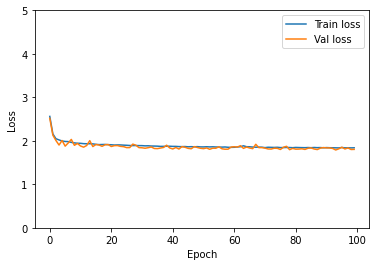

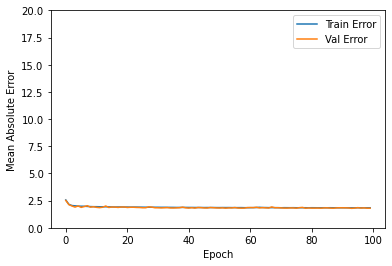

In [421]:
plot_history(history)

## Modelo 2: Aceleraciones críticas como input

### Eje horizontal

In [422]:
def build_model_amax():
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 3, activation='relu'))
    #Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    return(NN_model)

model_H = build_model_amax()
model_V = build_model_amax()
model_H.summary()

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_339 (Dense)            (None, 128)               512       
_________________________________________________________________
dense_340 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_341 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_342 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_343 (Dense)            (None, 1)                 257       
Total params: 165,377
Trainable params: 165,377
Non-trainable params: 0
_________________________________________________________________


In [423]:
#Definimos conjunto train-test
aux= DF[['HE','a1x', 'a2x', 'HF']]
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['HF'].copy()
xtrain = train_dataset.drop(['HF'], axis=1)
ytest = test_dataset['HF'].copy()
xtest = test_dataset.drop(['HF'], axis=1)

aux

,HE,a1x,a2x,HF
0,-0.250244,-43288.855469,30689.656250,-14.898682
1,-12.518311,36542.414062,-18693.505859,0.634766
2,-0.445557,7027.291504,-5259.004395,0.436401
3,0.112915,-8851.686523,5309.998047,-1.303101
4,-0.476074,-5502.908691,4693.156250,-0.537109
...,...,...,...,...
119671,-9.442139,15374.960938,-5929.227539,-1.043701
119672,-3.060913,38023.445312,-17270.132812,7.403564
119673,2.679443,-40895.136719,26336.900391,-6.262207
119674,-4.071045,28052.982422,-21735.427734,3.842163


In [424]:
#Entrenamos modelo horizontal
model_H.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_H.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 7s 3ms/step - loss: 10.3457 - mean_absolute_error: 10.3457 - val_loss: 4.2842 - val_mean_absolute_error: 4.2842
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 4.3512 - mean_absolute_error: 4.3512 - val_loss: 4.4459 - val_mean_absolute_error: 4.4459
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 4.2434 - mean_absolute_error: 4.2434 - val_loss: 4.2443 - val_mean_absolute_error: 4.2443
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 4.0215 - mean_absolute_error: 4.0215 - val_loss: 3.6708 - val_mean_absolute_error: 3.6708
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.5844 - mean_absolute_error: 3.5844 - val_loss: 3.4334 - val_mean_absolute_error: 3.4334
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.4932 - mean_absolute_error: 3.4932 - val_loss: 3.3123 - val_mean_absolute_error: 3.3

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5769 - mean_absolute_error: 2.5769 - val_loss: 2.4301 - val_mean_absolute_error: 2.4301
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5379 - mean_absolute_error: 2.5379 - val_loss: 2.7732 - val_mean_absolute_error: 2.7732
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5457 - mean_absolute_error: 2.5457 - val_loss: 2.7375 - val_mean_absolute_error: 2.7375
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5378 - mean_absolute_error: 2.5378 - val_loss: 2.6279 - val_mean_absolute_error: 2.6279
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5531 - mean_absolute_error: 2.5531 - val_loss: 2.5264 - val_mean_absolute_error: 2.5264
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5726 - mean_absolute_error: 2.5726 - val_loss: 2.5024 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4960 - mean_absolute_error: 2.4960 - val_loss: 2.4686 - val_mean_absolute_error: 2.4686
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5306 - mean_absolute_error: 2.5306 - val_loss: 2.5197 - val_mean_absolute_error: 2.5197


In [425]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,2.502641,2.502641,2.481249,2.481249,95
96,2.522032,2.522032,2.526142,2.526142,96
97,2.508213,2.508213,2.789664,2.789664,97
98,2.520046,2.520046,2.468550,2.468550,98
99,2.506530,2.506530,2.519682,2.519682,99


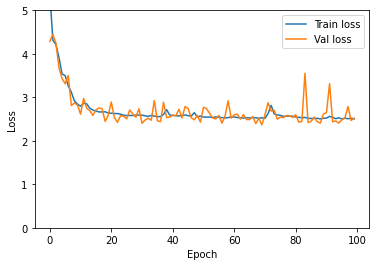

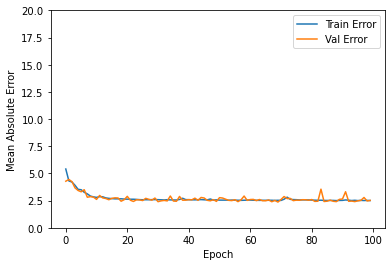

In [426]:
plot_history(history)

### Eje vertical

In [427]:
#Definimos conjunto train-test
aux= DF[['VE','a1y', 'a2y', 'VF']]
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['VF'].copy()
xtrain = train_dataset.drop(['VF'], axis=1)
ytest = test_dataset['VF'].copy()
xtest = test_dataset.drop(['VF'], axis=1)

aux

,VE,a1y,a2y,VF
0,-0.100708,3972.998535,-3082.689209,0.262451
1,-0.186157,-4570.212891,3923.957520,-0.222778
2,-0.399780,38158.203125,-23832.423828,14.346313
3,11.608887,-30694.126953,24962.136719,-2.374268
4,-0.350952,-31920.658203,20626.839844,-13.647461
...,...,...,...,...
119671,-0.549316,15023.249023,-6221.041504,2.886963
119672,0.125122,-2647.665039,4205.541992,0.238037
119673,0.180054,2898.032471,-3757.065186,0.701904
119674,-0.018311,3630.834717,-3628.141113,-0.012207


In [428]:
#Entrenamos modelo
model_V.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_V.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 7s 3ms/step - loss: 7.8635 - mean_absolute_error: 7.8635 - val_loss: 3.8278 - val_mean_absolute_error: 3.8278
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.8098 - mean_absolute_error: 3.8098 - val_loss: 3.6606 - val_mean_absolute_error: 3.6606
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.7652 - mean_absolute_error: 3.7652 - val_loss: 3.6695 - val_mean_absolute_error: 3.6695
Epoch 4/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.7138 - mean_absolute_error: 3.7138 - val_loss: 3.7126 - val_mean_absolute_error: 3.7126
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.6361 - mean_absolute_error: 3.6361 - val_loss: 3.2358 - val_mean_absolute_error: 3.2358
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.2633 - mean_absolute_error: 3.2633 - val_loss: 3.0758 - val_mean_absolute_error: 3.075

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1436 - mean_absolute_error: 2.1436 - val_loss: 2.1827 - val_mean_absolute_error: 2.1827
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1520 - mean_absolute_error: 2.1520 - val_loss: 2.1457 - val_mean_absolute_error: 2.1457
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1472 - mean_absolute_error: 2.1472 - val_loss: 2.4791 - val_mean_absolute_error: 2.4791
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1420 - mean_absolute_error: 2.1420 - val_loss: 2.0484 - val_mean_absolute_error: 2.0484
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1631 - mean_absolute_error: 2.1631 - val_loss: 2.0634 - val_mean_absolute_error: 2.0634
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1611 - mean_absolute_error: 2.1611 - val_loss: 2.0305 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1103 - mean_absolute_error: 2.1103 - val_loss: 2.1386 - val_mean_absolute_error: 2.1386
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.0804 - mean_absolute_error: 2.0804 - val_loss: 2.0462 - val_mean_absolute_error: 2.0462


In [429]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,2.102395,2.102395,2.177479,2.177479,95
96,2.112338,2.112338,2.033744,2.033744,96
97,2.104211,2.104211,2.281091,2.281091,97
98,2.105470,2.105470,2.138616,2.138616,98
99,2.102334,2.102334,2.046161,2.046161,99


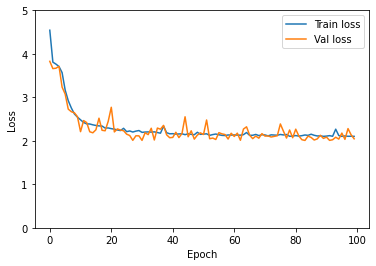

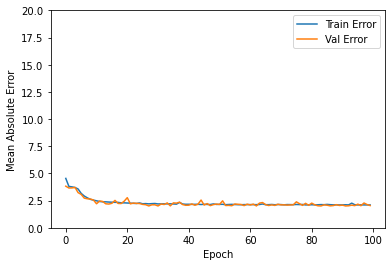

In [430]:
plot_history(history)

## Modelo 3: Empleando curva de velocidad
### 15 primeros valores
#### Eje horizontal

In [431]:
def build_model_v15():
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 16, activation='relu'))
    #Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    return(NN_model)

model_H = build_model_v15()
model_V = build_model_v15()
model_H.summary()

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_349 (Dense)            (None, 128)               2176      
_________________________________________________________________
dense_350 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_351 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_352 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_353 (Dense)            (None, 1)                 257       
Total params: 167,041
Trainable params: 167,041
Non-trainable params: 0
_________________________________________________________________


In [432]:
#Creamos DF auxiliar con las velocidades deseadas
new = DF["VX"].str.split(",", n = 16, expand = True)
n = new.drop([0,16], axis=1)
# Convertimos todos los elementos a numericos
cols = n.columns
n[cols] = n[cols].apply(pd.to_numeric, errors='coerce')
# Concatenamos al dataset original que usaremos
aux= pd.concat([DF[['HE','HF']], n], axis=1)
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['HF'].copy()
xtrain = train_dataset.drop(['HF'], axis=1)
ytest = test_dataset['HF'].copy()
xtest = test_dataset.drop(['HF'], axis=1)

aux

,HE,HF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.250244,-14.898682,-21.362305,-48.828125,-85.449219,-134.277344,-186.157227,-241.088867,-299.072266,-335.693359,-399.780273,-427.246094,-451.660156,-460.815430,-469.970703,-473.022461,-497.436523
1,-12.518311,0.634766,18.310547,39.672852,76.293945,94.604492,137.329102,186.157227,222.778320,274.658203,302.124023,347.900391,372.314453,418.090820,430.297852,445.556641,457.763672
2,-0.445557,0.436401,3.051758,21.362305,30.517578,51.879883,39.672852,45.776367,54.931641,57.983398,57.983398,54.931641,51.879883,48.828125,36.621094,48.828125,54.931641
3,0.112915,-1.303101,12.207031,12.207031,15.258789,9.155273,-12.207031,-36.621094,3.051758,0.000000,-33.569336,-42.724609,-54.931641,-79.345703,-91.552734,-76.293945,-73.242187
4,-0.476074,-0.537109,-9.155273,9.155273,3.051758,6.103516,-3.051758,3.051758,6.103516,0.000000,12.207031,15.258789,15.258789,6.103516,0.000000,-27.465820,-27.465820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119671,-9.442139,-1.043701,33.569336,39.672852,70.190430,88.500977,91.552734,103.759766,115.966797,115.966797,143.432617,149.536133,161.743164,161.743164,173.950195,164.794922,180.053711
119672,-3.060913,7.403564,9.155273,48.828125,79.345703,125.122070,170.898438,222.778320,259.399414,323.486328,344.848633,378.417969,378.417969,396.728516,411.987305,408.935547,405.883789
119673,2.679443,-6.262207,-24.414063,-36.621094,-91.552734,-152.587891,-201.416016,-265.502930,-314.331055,-350.952148,-372.314453,-399.780273,-387.573242,-393.676758,-408.935547,-399.780273,-402.832031
119674,-4.071045,3.842163,27.465820,51.879883,97.656250,112.915039,140.380859,183.105469,210.571289,244.140625,274.658203,292.968750,317.382812,305.175781,314.331055,323.486328,317.382812


In [433]:
#Entrenamos modelo
model_H.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_H.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.8448 - mean_absolute_error: 3.8448 - val_loss: 3.1361 - val_mean_absolute_error: 3.1361
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.8656 - mean_absolute_error: 2.8656 - val_loss: 2.6055 - val_mean_absolute_error: 2.6055
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.6938 - mean_absolute_error: 2.6938 - val_loss: 2.9278 - val_mean_absolute_error: 2.9278
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5499 - mean_absolute_error: 2.5499 - val_loss: 2.4019 - val_mean_absolute_error: 2.4019
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4764 - mean_absolute_error: 2.4764 - val_loss: 2.3718 - val_mean_absolute_error: 2.3718
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4551 - mean_absolute_error: 2.4551 - val_loss: 2.8608 - val_mean_absolute_error: 2.860

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1672 - mean_absolute_error: 2.1672 - val_loss: 2.1302 - val_mean_absolute_error: 2.1302
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1476 - mean_absolute_error: 2.1476 - val_loss: 2.1607 - val_mean_absolute_error: 2.1607
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1549 - mean_absolute_error: 2.1549 - val_loss: 2.1511 - val_mean_absolute_error: 2.1511
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1500 - mean_absolute_error: 2.1500 - val_loss: 2.1590 - val_mean_absolute_error: 2.1590
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1412 - mean_absolute_error: 2.1412 - val_loss: 2.1386 - val_mean_absolute_error: 2.1386
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1431 - mean_absolute_error: 2.1431 - val_loss: 2.2841 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1021 - mean_absolute_error: 2.1021 - val_loss: 2.1672 - val_mean_absolute_error: 2.1672
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1105 - mean_absolute_error: 2.1105 - val_loss: 2.1370 - val_mean_absolute_error: 2.1370


In [434]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,2.150645,2.150645,2.146586,2.146586,95
96,2.105287,2.105287,2.193369,2.193369,96
97,2.110763,2.110763,2.168719,2.168719,97
98,2.104980,2.104980,2.167184,2.167184,98
99,2.156143,2.156143,2.137035,2.137035,99


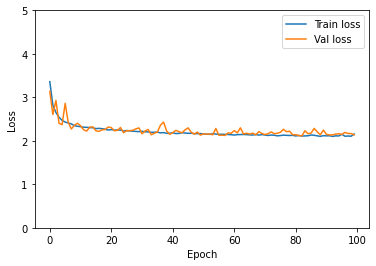

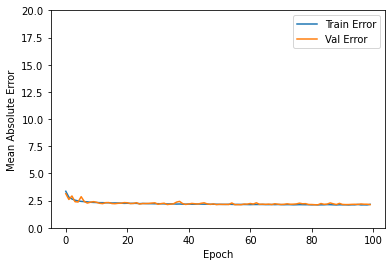

In [435]:
plot_history(history)

#### Eje vertical

In [436]:
#Creamos DF auxiliar con las velocidades deseadas
new = DF["VY"].str.split(",", n = 16, expand = True)
n = new.drop([0,16], axis=1)
# Convertimos todos los elementos a numericos
cols = n.columns
n[cols] = n[cols].apply(pd.to_numeric, errors='coerce')
# Concatenamos al dataset original que usaremos
aux= pd.concat([DF[['VE','VF']], n], axis=1)
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['VF'].copy()
xtrain = train_dataset.drop(['VF'], axis=1)
ytest = test_dataset['VF'].copy()
xtest = test_dataset.drop(['VF'], axis=1)

aux

,VE,VF,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.100708,0.262451,3.051758,9.155273,3.051758,-3.051758,-12.207031,-9.155273,-15.258789,-6.103516,-21.362305,-12.207031,-21.362305,-12.207031,-9.155273,3.051758,0.000000
1,-0.186157,-0.222778,0.000000,0.000000,3.051758,-12.207031,-24.414063,-33.569336,-27.465820,-42.724609,-27.465820,-36.621094,-42.724609,-48.828125,-45.776367,-45.776367,-33.569336
2,-0.399780,14.346313,9.155273,30.517578,61.035156,85.449219,125.122070,161.743164,204.467773,238.037109,299.072266,335.693359,381.469727,402.832031,442.504883,451.660156,485.229492
3,11.608887,-2.374268,-30.517578,-36.621094,-57.983398,-76.293945,-112.915039,-146.484375,-186.157227,-219.726562,-247.192383,-271.606445,-308.227539,-329.589844,-366.210937,-402.832031,-433.349609
4,-0.350952,-13.647461,-24.414063,-36.621094,-51.879883,-73.242188,-91.552734,-125.122070,-164.794922,-207.519531,-238.037109,-274.658203,-299.072266,-332.641602,-369.262695,-396.728516,-408.935547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119671,-0.549316,2.886963,6.103516,15.258789,39.672852,57.983398,94.604492,88.500977,125.122070,128.173828,140.380859,140.380859,134.277344,149.536133,140.380859,140.380859,152.587891
119672,0.125122,0.238037,9.155273,-18.310547,-15.258789,-24.414063,-6.103516,-12.207031,-15.258789,-9.155273,-12.207031,-12.207031,-36.621094,-24.414063,-3.051758,-9.155273,-24.414062
119673,0.180054,0.701904,-3.051758,21.362305,3.051758,15.258789,0.000000,6.103516,18.310547,27.465820,24.414063,33.569336,27.465820,33.569336,24.414062,30.517578,24.414063
119674,-0.018311,-0.012207,9.155273,-6.103516,-3.051758,-15.258789,21.362305,9.155273,21.362305,15.258789,30.517578,21.362305,18.310547,6.103516,18.310547,18.310547,15.258789


In [437]:
#Entrenamos modelo
model_V.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_V.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.4364 - mean_absolute_error: 3.4364 - val_loss: 2.6322 - val_mean_absolute_error: 2.6322
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4424 - mean_absolute_error: 2.4424 - val_loss: 2.3133 - val_mean_absolute_error: 2.3133
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2098 - mean_absolute_error: 2.2098 - val_loss: 2.0312 - val_mean_absolute_error: 2.0312
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1730 - mean_absolute_error: 2.1730 - val_loss: 2.0620 - val_mean_absolute_error: 2.0620
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.0915 - mean_absolute_error: 2.0915 - val_loss: 1.9924 - val_mean_absolute_error: 1.9924
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.0393 - mean_absolute_error: 2.0393 - val_loss: 1.8907 - val_mean_absolute_error: 1.890

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8254 - mean_absolute_error: 1.8254 - val_loss: 1.8875 - val_mean_absolute_error: 1.8875
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8218 - mean_absolute_error: 1.8218 - val_loss: 1.8182 - val_mean_absolute_error: 1.8182
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.7951 - mean_absolute_error: 1.7951 - val_loss: 1.7635 - val_mean_absolute_error: 1.7635
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8030 - mean_absolute_error: 1.8030 - val_loss: 1.8573 - val_mean_absolute_error: 1.8573
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8143 - mean_absolute_error: 1.8143 - val_loss: 1.8392 - val_mean_absolute_error: 1.8392
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8029 - mean_absolute_error: 1.8029 - val_loss: 1.8581 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.7404 - mean_absolute_error: 1.7404 - val_loss: 1.8622 - val_mean_absolute_error: 1.8622
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.7686 - mean_absolute_error: 1.7686 - val_loss: 1.8282 - val_mean_absolute_error: 1.8282


In [438]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,1.769091,1.769091,1.798759,1.798759,95
96,1.774914,1.774914,1.791404,1.791404,96
97,1.777443,1.777443,1.779643,1.779643,97
98,1.763198,1.763198,1.862200,1.862200,98
99,1.773182,1.773182,1.828184,1.828184,99


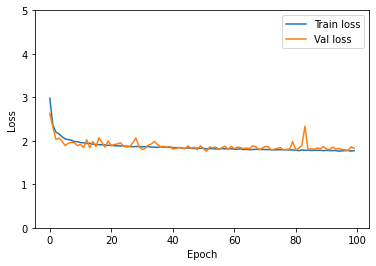

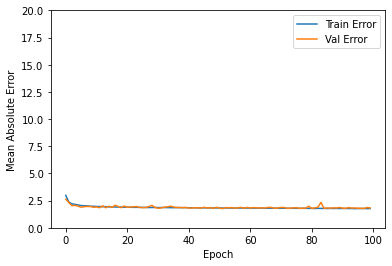

In [439]:
plot_history(history)

### 10 primeros valores
#### Eje horizontal

In [440]:
def build_model_v10():
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 11, activation='relu'))
    #Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    return(NN_model)

model_H = build_model_v10()
model_V = build_model_v10()
model_H.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_359 (Dense)            (None, 128)               1536      
_________________________________________________________________
dense_360 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_361 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_362 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_363 (Dense)            (None, 1)                 257       
Total params: 166,401
Trainable params: 166,401
Non-trainable params: 0
_________________________________________________________________


In [441]:
#Creamos DF auxiliar con las velocidades deseadas
new = DF["VX"].str.split(",", n = 11, expand = True)
n = new.drop([0,11], axis=1)
# Convertimos todos los elementos a numericos
cols = n.columns
n[cols] = n[cols].apply(pd.to_numeric, errors='coerce')
# Concatenamos al dataset original que usaremos
aux= pd.concat([DF[['HE','HF']], n], axis=1)
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['HF'].copy()
xtrain = train_dataset.drop(['HF'], axis=1)
ytest = test_dataset['HF'].copy()
xtest = test_dataset.drop(['HF'], axis=1)

aux

,HE,HF,1,2,3,4,5,6,7,8,9,10
0,-0.250244,-14.898682,-21.362305,-48.828125,-85.449219,-134.277344,-186.157227,-241.088867,-299.072266,-335.693359,-399.780273,-427.246094
1,-12.518311,0.634766,18.310547,39.672852,76.293945,94.604492,137.329102,186.157227,222.778320,274.658203,302.124023,347.900391
2,-0.445557,0.436401,3.051758,21.362305,30.517578,51.879883,39.672852,45.776367,54.931641,57.983398,57.983398,54.931641
3,0.112915,-1.303101,12.207031,12.207031,15.258789,9.155273,-12.207031,-36.621094,3.051758,0.000000,-33.569336,-42.724609
4,-0.476074,-0.537109,-9.155273,9.155273,3.051758,6.103516,-3.051758,3.051758,6.103516,0.000000,12.207031,15.258789
...,...,...,...,...,...,...,...,...,...,...,...,...
119671,-9.442139,-1.043701,33.569336,39.672852,70.190430,88.500977,91.552734,103.759766,115.966797,115.966797,143.432617,149.536133
119672,-3.060913,7.403564,9.155273,48.828125,79.345703,125.122070,170.898438,222.778320,259.399414,323.486328,344.848633,378.417969
119673,2.679443,-6.262207,-24.414063,-36.621094,-91.552734,-152.587891,-201.416016,-265.502930,-314.331055,-350.952148,-372.314453,-399.780273
119674,-4.071045,3.842163,27.465820,51.879883,97.656250,112.915039,140.380859,183.105469,210.571289,244.140625,274.658203,292.968750


In [442]:
#Entrenamos modelo
model_H.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_H.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.5997 - mean_absolute_error: 3.5997 - val_loss: 3.0887 - val_mean_absolute_error: 3.0887
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.8712 - mean_absolute_error: 2.8712 - val_loss: 2.6203 - val_mean_absolute_error: 2.6203
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.6520 - mean_absolute_error: 2.6520 - val_loss: 2.6997 - val_mean_absolute_error: 2.6997
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5896 - mean_absolute_error: 2.5896 - val_loss: 2.6097 - val_mean_absolute_error: 2.6097
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5511 - mean_absolute_error: 2.5511 - val_loss: 2.7242 - val_mean_absolute_error: 2.7242
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.5217 - mean_absolute_error: 2.5217 - val_loss: 2.5485 - val_mean_absolute_error: 2.548

Epoch 50/100
2394/2394 [==============================] - 8s 3ms/step - loss: 2.2725 - mean_absolute_error: 2.2725 - val_loss: 2.2861 - val_mean_absolute_error: 2.2861
Epoch 51/100
2394/2394 [==============================] - 8s 3ms/step - loss: 2.2434 - mean_absolute_error: 2.2434 - val_loss: 2.3079 - val_mean_absolute_error: 2.3079
Epoch 52/100
2394/2394 [==============================] - 8s 3ms/step - loss: 2.2723 - mean_absolute_error: 2.2723 - val_loss: 2.2939 - val_mean_absolute_error: 2.2939
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2523 - mean_absolute_error: 2.2523 - val_loss: 2.3260 - val_mean_absolute_error: 2.3260
Epoch 54/100
2394/2394 [==============================] - 8s 3ms/step - loss: 2.2554 - mean_absolute_error: 2.2554 - val_loss: 2.2666 - val_mean_absolute_error: 2.2666
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2356 - mean_absolute_error: 2.2356 - val_loss: 2.2637 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1891 - mean_absolute_error: 2.1891 - val_loss: 2.2856 - val_mean_absolute_error: 2.2856
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1734 - mean_absolute_error: 2.1734 - val_loss: 2.2806 - val_mean_absolute_error: 2.2806


In [443]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,2.204847,2.204847,2.307513,2.307513,95
96,2.212330,2.212330,2.290798,2.290798,96
97,2.197367,2.197367,2.298966,2.298966,97
98,2.189213,2.189213,2.285640,2.285640,98
99,2.203157,2.203157,2.280575,2.280575,99


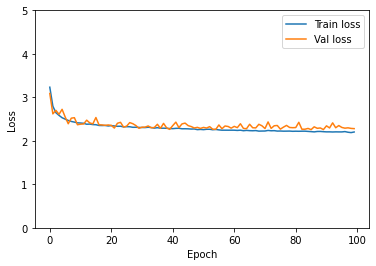

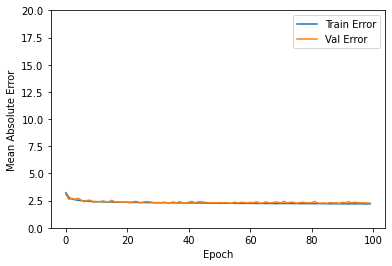

In [444]:
plot_history(history)

#### Eje vertical

In [445]:
#Creamos DF auxiliar con las velocidades deseadas
new = DF["VY"].str.split(",", n = 11, expand = True)
n = new.drop([0,11], axis=1)
# Convertimos todos los elementos a numericos
cols = n.columns
n[cols] = n[cols].apply(pd.to_numeric, errors='coerce')
# Concatenamos al dataset original que usaremos
aux= pd.concat([DF[['VE','VF']], n], axis=1)
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['VF'].copy()
xtrain = train_dataset.drop(['VF'], axis=1)
ytest = test_dataset['VF'].copy()
xtest = test_dataset.drop(['VF'], axis=1)

aux

,VE,VF,1,2,3,4,5,6,7,8,9,10
0,-0.100708,0.262451,3.051758,9.155273,3.051758,-3.051758,-12.207031,-9.155273,-15.258789,-6.103516,-21.362305,-12.207031
1,-0.186157,-0.222778,0.000000,0.000000,3.051758,-12.207031,-24.414063,-33.569336,-27.465820,-42.724609,-27.465820,-36.621094
2,-0.399780,14.346313,9.155273,30.517578,61.035156,85.449219,125.122070,161.743164,204.467773,238.037109,299.072266,335.693359
3,11.608887,-2.374268,-30.517578,-36.621094,-57.983398,-76.293945,-112.915039,-146.484375,-186.157227,-219.726562,-247.192383,-271.606445
4,-0.350952,-13.647461,-24.414063,-36.621094,-51.879883,-73.242188,-91.552734,-125.122070,-164.794922,-207.519531,-238.037109,-274.658203
...,...,...,...,...,...,...,...,...,...,...,...,...
119671,-0.549316,2.886963,6.103516,15.258789,39.672852,57.983398,94.604492,88.500977,125.122070,128.173828,140.380859,140.380859
119672,0.125122,0.238037,9.155273,-18.310547,-15.258789,-24.414063,-6.103516,-12.207031,-15.258789,-9.155273,-12.207031,-12.207031
119673,0.180054,0.701904,-3.051758,21.362305,3.051758,15.258789,0.000000,6.103516,18.310547,27.465820,24.414063,33.569336
119674,-0.018311,-0.012207,9.155273,-6.103516,-3.051758,-15.258789,21.362305,9.155273,21.362305,15.258789,30.517578,21.362305


In [446]:
#Entrenamos modelo
model_V.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_V.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.4057 - mean_absolute_error: 3.4057 - val_loss: 2.4304 - val_mean_absolute_error: 2.4304
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4544 - mean_absolute_error: 2.4544 - val_loss: 2.3545 - val_mean_absolute_error: 2.3545
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.3081 - mean_absolute_error: 2.3081 - val_loss: 2.2930 - val_mean_absolute_error: 2.2930
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2212 - mean_absolute_error: 2.2212 - val_loss: 2.1554 - val_mean_absolute_error: 2.1554
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1850 - mean_absolute_error: 2.1850 - val_loss: 2.1088 - val_mean_absolute_error: 2.1088
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1480 - mean_absolute_error: 2.1480 - val_loss: 2.1544 - val_mean_absolute_error: 2.154

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.9457 - mean_absolute_error: 1.9457 - val_loss: 1.9857 - val_mean_absolute_error: 1.9857
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.9395 - mean_absolute_error: 1.9395 - val_loss: 2.0061 - val_mean_absolute_error: 2.0061
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.9392 - mean_absolute_error: 1.9392 - val_loss: 2.0619 - val_mean_absolute_error: 2.0619
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.9263 - mean_absolute_error: 1.9263 - val_loss: 1.9126 - val_mean_absolute_error: 1.9126
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.9279 - mean_absolute_error: 1.9279 - val_loss: 2.1047 - val_mean_absolute_error: 2.1047
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.9407 - mean_absolute_error: 1.9407 - val_loss: 1.9572 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8433 - mean_absolute_error: 1.8433 - val_loss: 1.9526 - val_mean_absolute_error: 1.9526
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 1.8427 - mean_absolute_error: 1.8427 - val_loss: 2.0024 - val_mean_absolute_error: 2.0024


In [447]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,1.850455,1.850455,1.962479,1.962479,95
96,1.853536,1.853536,1.983672,1.983672,96
97,1.862292,1.862292,1.948366,1.948366,97
98,1.853868,1.853868,1.952593,1.952593,98
99,1.853959,1.853959,2.002432,2.002432,99


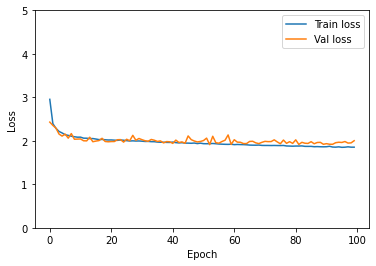

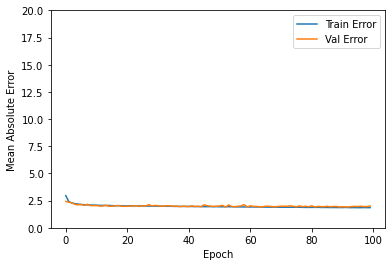

In [448]:
plot_history(history)

### 5 primeros valores
#### Eje horizontal

In [449]:
def build_model_v5():
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 6, activation='relu'))
    #Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    return(NN_model)

model_H = build_model_v5()
model_V = build_model_v5()
model_H.summary()

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_369 (Dense)            (None, 128)               896       
_________________________________________________________________
dense_370 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_371 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_372 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_373 (Dense)            (None, 1)                 257       
Total params: 165,761
Trainable params: 165,761
Non-trainable params: 0
_________________________________________________________________


In [450]:
#Creamos DF auxiliar con las velocidades deseadas
new = DF["VX"].str.split(",", n = 6, expand = True)
n = new.drop([0,6], axis=1)
# Convertimos todos los elementos a numericos
cols = n.columns
n[cols] = n[cols].apply(pd.to_numeric, errors='coerce')
# Concatenamos al dataset original que usaremos
aux= pd.concat([DF[['HE','HF']], n], axis=1)
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['HF'].copy()
xtrain = train_dataset.drop(['HF'], axis=1)
ytest = test_dataset['HF'].copy()
xtest = test_dataset.drop(['HF'], axis=1)

aux

,HE,HF,1,2,3,4,5
0,-0.250244,-14.898682,-21.362305,-48.828125,-85.449219,-134.277344,-186.157227
1,-12.518311,0.634766,18.310547,39.672852,76.293945,94.604492,137.329102
2,-0.445557,0.436401,3.051758,21.362305,30.517578,51.879883,39.672852
3,0.112915,-1.303101,12.207031,12.207031,15.258789,9.155273,-12.207031
4,-0.476074,-0.537109,-9.155273,9.155273,3.051758,6.103516,-3.051758
...,...,...,...,...,...,...,...
119671,-9.442139,-1.043701,33.569336,39.672852,70.190430,88.500977,91.552734
119672,-3.060913,7.403564,9.155273,48.828125,79.345703,125.122070,170.898438
119673,2.679443,-6.262207,-24.414063,-36.621094,-91.552734,-152.587891,-201.416016
119674,-4.071045,3.842163,27.465820,51.879883,97.656250,112.915039,140.380859


In [451]:
#Entrenamos modelo
model_H.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_H.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.5967 - mean_absolute_error: 3.5967 - val_loss: 2.8116 - val_mean_absolute_error: 2.8116
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.8028 - mean_absolute_error: 2.8028 - val_loss: 2.6486 - val_mean_absolute_error: 2.6486
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.6932 - mean_absolute_error: 2.6932 - val_loss: 2.6407 - val_mean_absolute_error: 2.6407
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.6592 - mean_absolute_error: 2.6592 - val_loss: 2.6445 - val_mean_absolute_error: 2.6445
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.6421 - mean_absolute_error: 2.6421 - val_loss: 2.6359 - val_mean_absolute_error: 2.6359
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.6173 - mean_absolute_error: 2.6173 - val_loss: 2.8320 - val_mean_absolute_error: 2.832

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4485 - mean_absolute_error: 2.4485 - val_loss: 2.4885 - val_mean_absolute_error: 2.4885
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4583 - mean_absolute_error: 2.4583 - val_loss: 2.5422 - val_mean_absolute_error: 2.5422
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4588 - mean_absolute_error: 2.4588 - val_loss: 2.4660 - val_mean_absolute_error: 2.4660
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4294 - mean_absolute_error: 2.4294 - val_loss: 2.4833 - val_mean_absolute_error: 2.4833
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4737 - mean_absolute_error: 2.4737 - val_loss: 2.5200 - val_mean_absolute_error: 2.5200
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4522 - mean_absolute_error: 2.4522 - val_loss: 2.4994 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.3942 - mean_absolute_error: 2.3942 - val_loss: 2.5651 - val_mean_absolute_error: 2.5651
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.3981 - mean_absolute_error: 2.3981 - val_loss: 2.4784 - val_mean_absolute_error: 2.4784


In [452]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,2.396279,2.396279,2.499140,2.499140,95
96,2.405999,2.405999,2.527476,2.527476,96
97,2.394788,2.394788,2.494215,2.494215,97
98,2.398459,2.398459,2.565129,2.565129,98
99,2.399624,2.399624,2.478449,2.478449,99


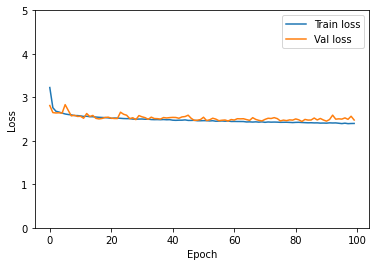

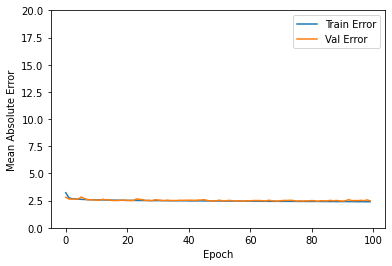

In [453]:
plot_history(history)

#### Eje Vertical

In [454]:
#Creamos DF auxiliar con las velocidades deseadas
new = DF["VY"].str.split(",", n = 6, expand = True)
n = new.drop([0,6], axis=1)
# Convertimos todos los elementos a numericos
cols = n.columns
n[cols] = n[cols].apply(pd.to_numeric, errors='coerce')
# Concatenamos al dataset original que usaremos
aux= pd.concat([DF[['VE','VF']], n], axis=1)
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['VF'].copy()
xtrain = train_dataset.drop(['VF'], axis=1)
ytest = test_dataset['VF'].copy()
xtest = test_dataset.drop(['VF'], axis=1)

aux

,VE,VF,1,2,3,4,5
0,-0.100708,0.262451,3.051758,9.155273,3.051758,-3.051758,-12.207031
1,-0.186157,-0.222778,0.000000,0.000000,3.051758,-12.207031,-24.414063
2,-0.399780,14.346313,9.155273,30.517578,61.035156,85.449219,125.122070
3,11.608887,-2.374268,-30.517578,-36.621094,-57.983398,-76.293945,-112.915039
4,-0.350952,-13.647461,-24.414063,-36.621094,-51.879883,-73.242188,-91.552734
...,...,...,...,...,...,...,...
119671,-0.549316,2.886963,6.103516,15.258789,39.672852,57.983398,94.604492
119672,0.125122,0.238037,9.155273,-18.310547,-15.258789,-24.414063,-6.103516
119673,0.180054,0.701904,-3.051758,21.362305,3.051758,15.258789,0.000000
119674,-0.018311,-0.012207,9.155273,-6.103516,-3.051758,-15.258789,21.362305


In [455]:
#Entrenamos modelo
model_V.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
history = model_V.fit(
  x, ytrain,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 3.3857 - mean_absolute_error: 3.3857 - val_loss: 2.5930 - val_mean_absolute_error: 2.5930
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.6332 - mean_absolute_error: 2.6332 - val_loss: 2.5420 - val_mean_absolute_error: 2.5420
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4741 - mean_absolute_error: 2.4741 - val_loss: 2.4716 - val_mean_absolute_error: 2.4716
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4628 - mean_absolute_error: 2.4628 - val_loss: 2.3468 - val_mean_absolute_error: 2.3468
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4429 - mean_absolute_error: 2.4429 - val_loss: 2.4013 - val_mean_absolute_error: 2.4013
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.4185 - mean_absolute_error: 2.4185 - val_loss: 2.5118 - val_mean_absolute_error: 2.511

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2207 - mean_absolute_error: 2.2207 - val_loss: 2.2414 - val_mean_absolute_error: 2.2414
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2173 - mean_absolute_error: 2.2173 - val_loss: 2.2818 - val_mean_absolute_error: 2.2818
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.2395 - mean_absolute_error: 2.2395 - val_loss: 2.2594 - val_mean_absolute_error: 2.2594
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1814 - mean_absolute_error: 2.1814 - val_loss: 2.2502 - val_mean_absolute_error: 2.2502
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1917 - mean_absolute_error: 2.1917 - val_loss: 2.2423 - val_mean_absolute_error: 2.2423
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1642 - mean_absolute_error: 2.1642 - val_loss: 2.3715 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1333 - mean_absolute_error: 2.1333 - val_loss: 2.2404 - val_mean_absolute_error: 2.2404
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 2.1219 - mean_absolute_error: 2.1219 - val_loss: 2.2477 - val_mean_absolute_error: 2.2477


In [456]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,2.125125,2.125125,2.243802,2.243802,95
96,2.127810,2.127810,2.247892,2.247892,96
97,2.129400,2.129400,2.251996,2.251996,97
98,2.132316,2.132316,2.240355,2.240355,98
99,2.125487,2.125487,2.247679,2.247679,99


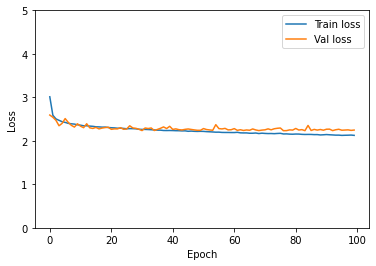

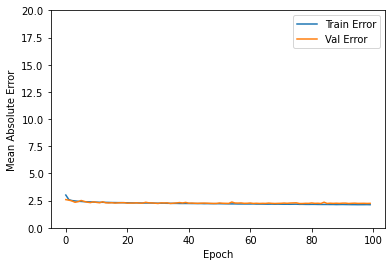

In [457]:
plot_history(history)

## Otros Modelos
### xgboost

In [468]:
#Definimos conjunto train-test HORIZONTAL
aux= DF[['HE','VXmax','HF']]
train_dataset = aux.sample(frac=0.8,random_state=0)
test_dataset = aux.drop(train_dataset.index)

ytrain = train_dataset['HF'].copy()
xtrain = train_dataset.drop(['HF'], axis=1)
ytest = test_dataset['HF'].copy()
xtest = test_dataset.drop(['HF'], axis=1)

data_dmatrix = xgb.DMatrix(data=xtrain,label=ytrain)

#Definimos gridsearch para encontrar mejor modelo
models = []
for w in range(0, 5):
    models.append(xgb.XGBRegressor(max_depth = 6, min_child_weight = w, eta = 0.1))
                  
for m in models:
    cvresult = xgb.cv(m.get_xgb_params(), data_dmatrix, num_boost_round=m.get_params()['n_estimators'],
           nfold=5, metrics='rmse', early_stopping_rounds = 20)
    print(cvresult)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          7.189265        0.009329        7.192335       0.038493
1          6.630785        0.007479        6.636497       0.036413
2          6.138195        0.006659        6.146218       0.033138
3          5.704913        0.005326        5.716113       0.030705
4          5.325829        0.004791        5.340703       0.027808
..              ...             ...             ...            ...
71         2.989573        0.006911        3.109923       0.030968
72         2.988932        0.007062        3.109882       0.031140
73         2.988427        0.006950        3.109769       0.031002
74         2.987958        0.007153        3.109797       0.030956
75         2.987048        0.007051        3.109590       0.031114

[76 rows x 4 columns]
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0          7.189265        0.009329        7.192335       0.038493
1          6.630785        0.007479    

In [459]:
# #Mejor modelo
# final_model = xgb.XGBRegressor(max_depth = 6, min_child_weight = 1, eta = 0.1)
# final_model.fit(xtrain,ytrain)

### Regresión lineal

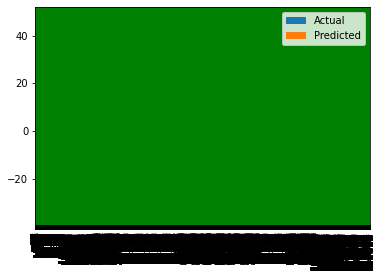

In [469]:
regressor = LinearRegression()
regressor.fit(xtrain[0:500], ytrain[0:500])#predicting the test set results
y_pred = regressor.predict(xtest)
df1 = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})
df1.plot(kind='bar')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### PCA sobre v10

In [461]:
def build_model_v10_pca():
    NN_model = Sequential()
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = 5, activation='relu'))
    #Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    return(NN_model)

model_H = build_model_v10_pca()
model_V = build_model_v10_pca()
model_H.summary()

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_379 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_380 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_381 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_382 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_383 (Dense)            (None, 1)                 257       
Total params: 165,633
Trainable params: 165,633
Non-trainable params: 0
_________________________________________________________________


In [462]:
#Creamos DF auxiliar con las velocidades deseadas
new = DF["VX"].str.split(",", n = 11, expand = True)
n = new.drop([0,11], axis=1)
# Convertimos todos los elementos a numericos
cols = n.columns
n[cols] = n[cols].apply(pd.to_numeric, errors='coerce')
# Concatenamos al dataset original que usaremos
aux= pd.concat([DF[['HE','HF']], n], axis=1)

aux

,HE,HF,1,2,3,4,5,6,7,8,9,10
0,-0.250244,-14.898682,-21.362305,-48.828125,-85.449219,-134.277344,-186.157227,-241.088867,-299.072266,-335.693359,-399.780273,-427.246094
1,-12.518311,0.634766,18.310547,39.672852,76.293945,94.604492,137.329102,186.157227,222.778320,274.658203,302.124023,347.900391
2,-0.445557,0.436401,3.051758,21.362305,30.517578,51.879883,39.672852,45.776367,54.931641,57.983398,57.983398,54.931641
3,0.112915,-1.303101,12.207031,12.207031,15.258789,9.155273,-12.207031,-36.621094,3.051758,0.000000,-33.569336,-42.724609
4,-0.476074,-0.537109,-9.155273,9.155273,3.051758,6.103516,-3.051758,3.051758,6.103516,0.000000,12.207031,15.258789
...,...,...,...,...,...,...,...,...,...,...,...,...
119671,-9.442139,-1.043701,33.569336,39.672852,70.190430,88.500977,91.552734,103.759766,115.966797,115.966797,143.432617,149.536133
119672,-3.060913,7.403564,9.155273,48.828125,79.345703,125.122070,170.898438,222.778320,259.399414,323.486328,344.848633,378.417969
119673,2.679443,-6.262207,-24.414063,-36.621094,-91.552734,-152.587891,-201.416016,-265.502930,-314.331055,-350.952148,-372.314453,-399.780273
119674,-4.071045,3.842163,27.465820,51.879883,97.656250,112.915039,140.380859,183.105469,210.571289,244.140625,274.658203,292.968750


In [463]:
#Aplicamos PCA y creamos los conjuntos de entrenamiento
y = aux["HF"].values
x = aux.drop(["HE", "HF"], axis=1).values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=4)
pcdf = pca.fit_transform(x)
res = pd.DataFrame(data = pcdf, columns = ['p1', 'p2','p3','p4'])
aux2 = pd.concat([aux[["HE", "HF"]], res], axis=1)
aux2.dropna(subset = ['p1', 'p2','p3','p4', 'HE', 'HF'], inplace=True)
aux2 = aux2.reset_index(drop=True)

train_dataset = aux2.sample(frac=0.8,random_state=0)
test_dataset = aux2.drop(train_dataset.index)

ytrain = train_dataset['HF'].copy()
xtrain = train_dataset.drop(['HF'], axis=1)
ytest = test_dataset['HF'].copy()
xtest = test_dataset.drop(['HF'], axis=1)
aux2

,HE,HF,p1,p2,p3,p4
0,-0.250244,-14.898682,-4.854397,0.429642,-0.076093,0.014489
1,-12.518311,0.634766,3.930290,-0.243318,0.021377,0.023019
2,-0.445557,0.436401,1.209420,0.032258,-0.452279,0.119625
3,0.112915,-1.303101,0.230739,0.715211,-0.162902,0.038810
4,-0.476074,-0.537109,0.111300,-0.324888,-0.390123,-0.095639
...,...,...,...,...,...,...
119669,-1.901245,-12.225342,2.833258,1.061131,-0.164099,0.258473
119670,-9.442139,-1.043701,4.444233,-0.751781,-0.309766,-0.007077
119671,-3.060913,7.403564,-4.970620,0.406559,-0.268921,-0.365248
119672,2.679443,-6.262207,4.160697,0.371836,-0.287778,0.221557


In [464]:
#Entrenamos modelo
model_H.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
x = np.asarray(xtrain).astype('float32')
y = np.asarray(ytrain).astype('float32')
history = model_H.fit(
  x, y,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/100
2394/2394 [==============================] - 8s 3ms/step - loss: 4.2655 - mean_absolute_error: 4.2655 - val_loss: 3.6369 - val_mean_absolute_error: 3.6369
Epoch 2/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.6359 - mean_absolute_error: 3.6359 - val_loss: 3.5922 - val_mean_absolute_error: 3.5922
Epoch 3/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.5604 - mean_absolute_error: 3.5604 - val_loss: 3.5176 - val_mean_absolute_error: 3.5176
Epoch 4/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.5672 - mean_absolute_error: 3.5672 - val_loss: 3.4839 - val_mean_absolute_error: 3.4839
Epoch 5/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.5423 - mean_absolute_error: 3.5423 - val_loss: 3.4868 - val_mean_absolute_error: 3.4868
Epoch 6/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.5160 - mean_absolute_error: 3.5160 - val_loss: 3.4593 - val_mean_absolute_error: 3.459

Epoch 50/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.2585 - mean_absolute_error: 3.2585 - val_loss: 3.3968 - val_mean_absolute_error: 3.3968
Epoch 51/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.3123 - mean_absolute_error: 3.3123 - val_loss: 3.4002 - val_mean_absolute_error: 3.4002
Epoch 52/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.2749 - mean_absolute_error: 3.2749 - val_loss: 3.4096 - val_mean_absolute_error: 3.4096
Epoch 53/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.3052 - mean_absolute_error: 3.3052 - val_loss: 3.4050 - val_mean_absolute_error: 3.4050
Epoch 54/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.2713 - mean_absolute_error: 3.2713 - val_loss: 3.3840 - val_mean_absolute_error: 3.3840
Epoch 55/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.2832 - mean_absolute_error: 3.2832 - val_loss: 3.4052 - val_mean_absolute_error:

Epoch 99/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.1625 - mean_absolute_error: 3.1625 - val_loss: 3.4286 - val_mean_absolute_error: 3.4286
Epoch 100/100
2394/2394 [==============================] - 7s 3ms/step - loss: 3.1136 - mean_absolute_error: 3.1136 - val_loss: 3.4527 - val_mean_absolute_error: 3.4527


In [465]:
#Metricas de entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,epoch
95,3.162415,3.162415,3.437480,3.437480,95
96,3.158396,3.158396,3.464894,3.464894,96
97,3.161093,3.161093,3.432516,3.432516,97
98,3.160281,3.160281,3.428608,3.428608,98
99,3.152804,3.152804,3.452740,3.452740,99


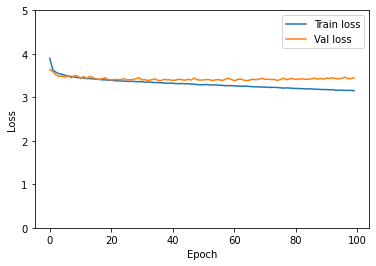

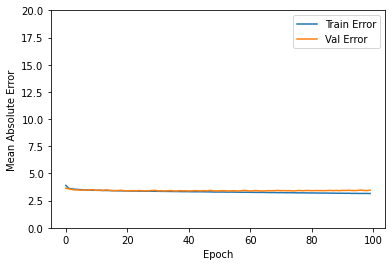

In [466]:
plot_history(history)